In [1]:
%matplotlib inline
import sklearn 
import models
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import os 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm as support
from sklearn.metrics import precision_score, roc_curve, auc 
from random import shuffle
import feature_extraction
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA


In [2]:
class SVM():

    def __init__(self, C=0.1):
        # initialize classifier
        self.clf = support.SVC(C=C, kernel='poly', degree=4, probability = True)
        #self.clf = svm.SVC(C=C, kernel='linear', probability = True)
    
    def train(self, X, y, name_list):
        # fit the classifier
        self.clf = self.clf.fit(X,y)

    def test(self, X, y):
        prediction = self.clf.predict(X)
        # get mean accuracy (not a good metric!)
        score = self.clf.score(X, y)
        precision = precision_score(y, prediction)
        return score, precision 

    def roc_auc(self, X, true):
        pred = self.clf.predict(X)
        fpr, tpr, thresholds = roc_curve(true, pred)
        auc_var = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC (AUC = %0.2f)' % (auc_var))
        plt.title('ROC Curve - SVM')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.savefig('ROC SVM V3')
        plt.show()
        plt.close()

def train_test_split(X, y, name_list, test_size=0.2, randomize=True) :
    # right now this just splits at the 80% line (no randomness)

    # need to make sure data from a single patient are all in the same category
    # each label is VXX.YYY, but with one to two Xs zero to three Ys
    # so we take XXYYY to be a unique label for a patient (is this true??) (maybe lol)
    # we then sort the data by those labels so that all the data from a given
    # patient is reunited with its source. 

    sort_by = list()

    for x in name_list :
        labels_split = x.split('.')
        part1 = labels_split[1][1:]
        if len(labels_split) == 2 :
            part2 = ''
        else :
            part2 = labels_split[2]

        sort_by.append(int(part1 + part2))

    # get a list with one of each name
    names_unique = list(set(sort_by))

    def shuffle_helper(elem) :
        return names_unique.index(elem[0])


    # if desired, randomize the order
    if randomize :
        shuffle(names_unique)

    # get a list with one of each name
    names_unique = list(set(sort_by))

    def shuffle_helper(elem) :
        return names_unique.index(elem[0])


    # if desired, randomize the order
    if randomize :
        shuffle(names_unique)

    indexing = range(0,len(sort_by))

    sort_by, indexing = (list(t) for t in zip(*sorted(zip(sort_by, indexing),key=shuffle_helper)))

    order = np.asarray(indexing)

    X_sorted = X[order]
    y_sorted = y[order]

    # we split at the closest multiple of 23 to the requested split point

    split_at = int(int(int(X.shape[0] * (1 - test_size)) / 23.0) * 23)

    X_train = X[:split_at,:]
    X_valid = X[split_at:,:]
    y_train = y[:split_at]
    y_valid = y[split_at:]
    return X_train, X_valid, y_train, y_valid

    


In [4]:
# SVM Model 
#=======
data, labels, name_list = feature_extraction.raw_data(two_cat = True)
#data = feature_extraction.features()
X_train, X_test, y_train, y_test = train_test_split(data, labels, name_list, test_size = 0.2)

svm = SVM()
svm.train(X_train, y_train, name_list)
svm_sc, svm_prec = svm.test(X_test,y_test)


# construct ROC curve for SVM
#svm.roc_auc(data, labels)

svm_cvsc = cross_val_score(svm.clf, data, labels, cv=5)

print('SVM Accuracy: ' + str(svm_sc))
print('SVM Precision: ' + str(svm_prec))
print('SVM Cross Validation Scores: ' + str(svm_cvsc))
print('Mean SVM Cross Validation Scores: ' + str(np.mean(svm_cvsc)))

/home/paperspace/.local/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/paperspace/.local/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/paperspace/.local/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/paperspace/.local/lib/python3.5/site-packages/

KeyboardInterrupt: 

2300


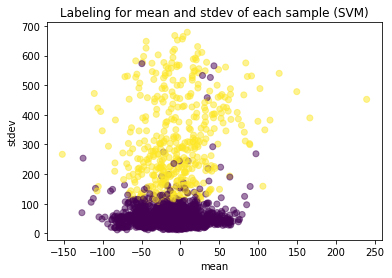

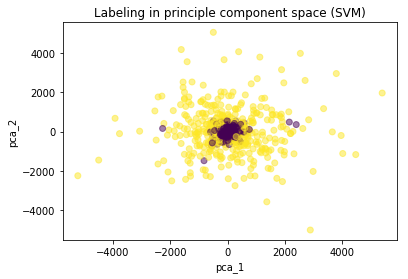

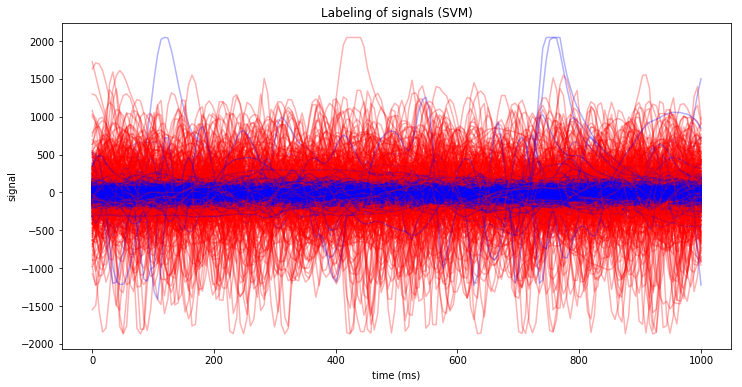

In [4]:
data, labels, name_list = feature_extraction.raw_data(two_cat = True)

labels_predict =  svm.clf.predict(X_test)
print(labels_predict.size)

pca = PCA()

data_pca = pca.fit_transform(X_test)

avges = np.mean(X_test,axis=1)
sigs = np.std(X_test,axis=1)

plt.figure()
plt.scatter(avges,sigs,alpha=0.5,c=labels_predict)
plt.xlabel('mean')
plt.ylabel('stdev')
plt.title('Labeling for mean and stdev of each sample (SVM)')
plt.savefig('Labeling for mean and stdev of each sample (SVM)')
plt.show()

plt.figure()
plt.scatter(data_pca[:,0],data_pca[:,1],alpha=0.5,c=labels_predict)
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.title('Labeling in principle component space (SVM)')
plt.show()

# now, plot the curves
t = np.linspace(0,1000,X_test.shape[1])
plt.figure(figsize=(12,6))
for i in range(X_test.shape[0]) :
    if labels_predict[i] > 0.5:
        plt.plot(t,X_test[i,:],'-r',alpha=0.3)
    else :
        plt.plot(t,X_test[i,:],'-b',alpha=0.3)

plt.xlabel('time (ms)')
plt.ylabel('signal')
plt.title('Labeling of signals (SVM)')
plt.savefig('Labeling of signals (SVM)')
plt.show()

In [ ]:
X = X_test[:,0:2] 
y = y_test
print(X.shape)

print("Model fitted")

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
print(xlim)

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
print(XX.shape)
#print(XX.ravel())
xy = np.vstack([XX.ravel(), YY.ravel()]).T
print(xy.shape)
Z = svm.clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(svm.clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()